# Introduction

1. Monte Carlo
2. t-test
2. Tukey
3. Pipeline
4. Hypothesis
    1. DO bigger customers get a higher discount?
    2. Do discounts lead to more revenue?
   Beneficiaries of discounts?
   
OUTLIER REMOVAL!!


## Import Libraries and Connect to Database

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sqlite3
from statsmodels.stats.multicomp import MultiComparison 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

<img src='Northwind_ERD_updated.png'>

In [4]:
q7= """
    SELECT 
        
        P.ProductName,
        OD.Quantity,
        OD.UnitPrice,
        OD.Discount AS DiscRate,
        (OD.UnitPrice * OD.Quantity) * (OD.Discount) AS DiscAmount,
        (OD.UnitPrice * OD.Quantity) * (1 - OD.Discount) AS TotalPaid,
        O.EmployeeId AS EmpID,
        E.Firstname || ' ' || E.LastName AS EmpName,
        C.CompanyName,
        C.ContactName,
        C.Id AS CustID,
        OD.Id As OrderID
        
    FROM OrderDetail as OD
    JOIN `Order` AS O ON OD.OrderID = O.Id 
    JOIN Product as P ON OD.ProductId = P.Id
    JOIN Employee AS E on E.Id = O.EmployeeId
    JOIN Customer AS C on C.Id = O.CustomerId
    
    
    ORDER BY EmployeeId ASC
    
    
"""

cursor = cur.execute(q7)
names = [description[0] for description in cursor.description]
df_master = pd.DataFrame(cursor.fetchall(),columns=names)
display(df_master)

,ProductName,Quantity,UnitPrice,DiscRate,DiscAmount,TotalPaid,EmpID,EmpName,CompanyName,ContactName,CustID,OrderID
0,Chang,50,15.2,0.2,152.00,608.00,1,Nancy Davolio,Ernst Handel,Roland Mendel,ERNSH,10258/2
1,Chef Anton's Gumbo Mix,65,17.0,0.2,221.00,884.00,1,Nancy Davolio,Ernst Handel,Roland Mendel,ERNSH,10258/5
2,Mascarpone Fabioli,6,25.6,0.2,30.72,122.88,1,Nancy Davolio,Ernst Handel,Roland Mendel,ERNSH,10258/32
3,Inlagd Sill,30,15.2,0.0,0.00,456.00,1,Nancy Davolio,Wartian Herkku,Pirkko Koskitalo,WARTH,10270/36
4,Ipoh Coffee,25,36.8,0.0,0.00,920.00,1,Nancy Davolio,Wartian Herkku,Pirkko Koskitalo,WARTH,10270/43
...,...,...,...,...,...,...,...,...,...,...,...,...
2073,Teatime Chocolate Biscuits,35,9.2,0.0,0.00,322.00,9,Anne Dodsworth,Hanari Carnes,Mario Pontes,HANAR,11022/19
2074,Gudbrandsdalsost,30,36.0,0.0,0.00,1080.00,9,Anne Dodsworth,Hanari Carnes,Mario Pontes,HANAR,11022/69
2075,Sir Rodney's Scones,3,10.0,0.0,0.00,30.00,9,Anne Dodsworth,Blauer See Delikatessen,Hanna Moos,BLAUS,11058/21
2076,Camembert Pierrot,21,34.0,0.0,0.00,714.00,9,Anne Dodsworth,Blauer See Delikatessen,Hanna Moos,BLAUS,11058/60


## Statistical Testing Functions 

In [27]:
def Cohen_d(control, experiment):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = experiment.mean() - control.mean()

    n1, n2 = len(experiment), len(control)
    var1 = experiment.var()
    var2 = control.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [35]:
def monte_carlo(a,b,size):
    """  Runs a monte carlo simulations on two pandas series (a and b)  """
    

    diff_mu_a_b = np.mean(b) - np.mean(a)
    num = 0
    denom = 0
    union = a.append(b,ignore_index=True)
       
    
    for i in range(size):
       
        # Generate ai
        ai = union.sample(len(a))
        
        # Generate its compliment as bi
        bi = union.drop(ai.index)
                 
        diff_mu_ai_bi = np.mean(bi) - np.mean(ai)
        
        if diff_mu_ai_bi >= diff_mu_a_b:
            num +=1
            
        denom += 1
        
    p_val = num/denom
    print("In {} samples, The mean of the experimental group was higher than the control group {} % percent of the time".format(size,p_val*100))
    return p_val
    
      

In [31]:

def hyp_test_mean(control,experiment):
    
    """ Tests the null hypothesis that an experimental sample comes from the same population as a control sample
        Runs a students t-test, a Welch's t-test and a Mann Whitney test, and then indicated which results are most reliable
        based on whether the assumptions for each respective test have been met or not. 

        Samples must be passed in as pandas series. 
    """
    
# 1. Test variances
    w,p_same_var = stats.levene(control,experiment)
# 2. Test nromality
    w,p_norm_a = stats.normaltest(control)
    w,p_norm_b = stats.normaltest(experiment)
    
# 3. Run tests
    
    t_test_result = stats.ttest_ind(control,experiment)[1]
    welch_result = stats.ttest_ind(control,experiment,equal_var=False)[1]
    mann_whitney_u = stats.mannwhitneyu(control,experiment)[1]
    
# 4. Choose best test

    norm_pass = ((p_norm_a >= 0.05) and (p_norm_b >= 0.05)) or ( (len(control) > 30) and (len(experiment) > 30) )
    var_pass = p_same_var >= 0.05
    
    if var_pass and norm_pass:
        t_test_notes = "1 !!Best Test!!"
        welch_notes = "not used; t-test assumptions met"
        mann_whitney_u_notes = "not needed; t-test assumptions met"
    elif norm_pass and not var_pass:
        welch_notes = "1 !!Best Test!!"
        t_test_notes = "not used: assumptions not met"
        mann_whitney_u_notes = "not needed: Welch's assumptions met"
    else:
        welch_notes = "not used: assumptions not met"
        t_test_notes = "not used: assumptions not met"
        mann_whitney_u_notes = "1 !!Best Test!!"

# 5. results in df
    test_name = ['t_test','Welch\'s t-test','Mann Whitney U']
    df_dict={
        'Difference in means': [0,(np.mean(experiment) - np.mean(control))],
        'Cohen\'s d': [0,Cohen_d(control,experiment)],
        'Sample A normality':[p_norm_a,'0'],
        'Samp B normality':[p_norm_b,'0'],
        'Variance similarity': [p_same_var,'0'],
        't_test':[t_test_result,t_test_notes],
        'Welch\'s t-test' :[welch_result,welch_notes],
        'Mann Whitney U':[mann_whitney_u,mann_whitney_u_notes]
        
    }
    
    df = pd.DataFrame.from_dict(df_dict,orient = 'index',columns=['p_value','notes'])
    df['Null Rejected'] = (df['p_value'] < 0.05)
    df['p_value'].round(4)
    display(df)
    return df

# First Hypothesis: **_Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?_**

<b>Null Hypthesis:</b>
Discounts do not cause people to purchase greater quantities of products

<b>Alternative Hypothesis:</b>People order a product in greater quantities if they are offered a discount

Lets load the relevant data. 

In [21]:
# ______________Dataframe with Quantity and Discount data on all orders_______________

q1= """
    SELECT Quantity,Discount 
    FROM OrderDetail 
    GROUP BY `Id`
"""

cursor = cur.execute(q1)
names = [description[0] for description in cursor.description]

df_all_orders = pd.DataFrame(cursor.fetchall(),columns=names)


# ______________Control Dataframe; Only has data just for orders where no discounts were applied______________

q2= """
    SELECT Quantity,Discount
    FROM OrderDetail 
    WHERE Discount = 0 
    GROUP BY `Id` 
"""

cursor = cur.execute(q2)
names = [description[0] for description in cursor.description]

df_no_discounts = pd.DataFrame(cursor.fetchall(),columns=names)


# ______________Experimental Dataframe; Only has data just for orders where no discounts were applied______________


q3= """
    SELECT Quantity,Discount
    FROM OrderDetail 
    WHERE Discount != 0 
    GROUP BY `Id` 
"""

cursor = cur.execute(q3)
names = [description[0] for description in cursor.description]

df_with_discounts = pd.DataFrame(cursor.fetchall(),columns=names)


## Testing the Null Hypothesis

Let us test the null hypothesis that the average quantity ordered is the same for orders with discounts applied as it is for orders with no discounts applied using the hypothesis testing pipeline function we defined above. 

This pipeline where check the sample sizes, whether the two samples are normally distributed and whether they have equal variance. It will then run a student's t-test, a Welch's t test andr a Mann Whitney U test on both samples, and tell us in the notes which test is most reliable based on whether or not the normality and variance assumptions have been met


In [22]:
df2 = hyp_test_mean(df_no_discounts['Quantity'],df_with_discounts['Quantity'])
display(df2)

,p_value,notes,Null Rejected
Difference in means,0.000000,5.394523,True
Cohen's d,0.000000,0.286272,True
Sample A normality,0.000000,0,True
Samp B normality,0.000000,0,True
Variance similarity,0.000121,0,True
t_test,0.000000,not used: assumptions not met,True
Welch's t-test,0.000000,1 !!Best Test!!,True
Mann Whitney U,0.000000,not needed: Welch's assumptions met,True


It seems that we the null hypothesis has been rejected by all tests, including the Welch's test which is indicated as being the best one given the status of normality and variance of the samples.

Lets run a Monte Carlo simualtion to double check the results. 

In [23]:
p = monte_carlo(df_no_discounts['Quantity'],df_with_discounts['Quantity'],10000)

print(p)

0.0


## Conclusion

It seems that there is a statistically significant increase in quantity ordered if a discount is being applied to the item in the order. The size of this increase for all levels of discount can be seen by the Cohen's d of 0.286 which is a small to moderate effect on the quantity ordered. 

Lets move to the second part of the question and take a closer look at effect sizes.

## Effect sizes at different levels of discount

Lets start of by running a pairwise Tukey's test on the discount levels to quickly get a sense of what the effect size is at different levels of discounts

In [ ]:
mc = MultiComparison(df_all_orders['Quantity'],df_all_orders['Discount'])
result = mc.tukeyhsd()

print(result)

Interesting: it seems there is a statistically significant difference in means at most of the discount levels. However, this resul oject is a little hard to interpret and has data on comparisons between discount levels, which is not pertinent to our inquiry. 

Lets manually examine the discount levels and their attendant effect sizes

In [ ]:
discount_levels = df_with_discounts['Discount'].value_counts()
display(discount_levels)

It seems there are some discount percentages that are rarely applied. They will most likely just add noise to our analysis and it might be best to dispense with them. Lets also convert the relevant discount sizes into a list we can iterate through later

In [ ]:
discount_list = list(discount_levels[discount_levels > 10].index)
display(discount_levels)

Now lets calculate the average quantity and Cohen's d at each relevant discount level. 
The code below will return a data frame with the mean quantity ordered, the difference from the null mean and the Cohen's for each level of discount. We will then plot the Cohen's d to assess the effect of each discount level on the quantity ordered. 

In [ ]:
df_dict = {}

for i in discount_list:
    disc_df = df_with_discounts[df_with_discounts['Discount'] == i]['Quantity']
    cohen_d= Cohen_d(df_no_discounts['Quantity'],disc_df)
    mean = disc_df.mean()
    mean_diff = disc_df.mean() - df_no_discounts['Quantity'].mean()
    df_dict[i] = [mean, mean_diff,cohen_d]

effects_df = pd.DataFrame.from_dict(df_dict,orient='index',columns=['Mean','Mean Difference','Cohen\'s D'])
display(effects_df)   

effects_df['Cohen\'s D'].plot(kind='bar')
plt.show()

## Conclusion

It seems that discounts of 5,20, 15 and 25 percent have the most effect on quantity ordered. What is interesting is that a 10% discount seems to have less of an effect on the quantity ordered. Perhaps its worth exploring the data further to see when a 10 percent discount is applied and what about those situations might lead to a reduced effect on quantity ordered. However, based just off the data we have before us, it might make sense to phase out the 10% discount altogether or reduce it to 5%. By doing so, we will offer less of a discount and thus lose less revenue since a 10% discount is not having much of an effect on increasing sales. 

# Second Hypothesis: does discount level lead to higher revenue?

<b> Null Hypothesis:</b> The revenue generated by discounted orders is the same as the revenue from ordes where not discount was applied. 

<b> Alt Hypothesis:</b> Discounted orders generate more revenue. 
    


,Discount,TotalPaid
0,0.05,15019.50
1,0.20,8432.00
2,0.20,8263.36
3,0.05,7509.75
4,0.25,6324.00
...,...,...
833,0.20,16.00
834,0.20,14.40
835,0.25,14.40
836,0.10,8.64


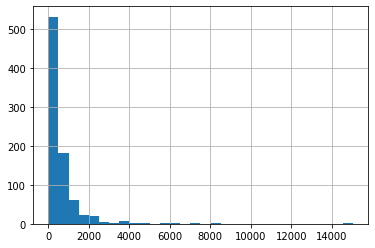

In [12]:
q4= """
    SELECT       
        Discount,          
        ((OrderDetail.UnitPrice * Quantity) * (1 - Discount)) AS TotalPaid
    FROM OrderDetail 
    JOIN Product ON OrderDetail.ProductId = Product.Id
    WHERE Discount !=0
    ORDER BY TotalPaid DESC
    
    
"""

cursor = cur.execute(q4)
names = [description[0] for description in cursor.description]
df_totals_disc = pd.DataFrame(cursor.fetchall(),columns=names)
display(df_totals_disc)
df_totals_disc['TotalPaid'].hist(bins = 30)

,Discount,TotalPaid
0,0.0,15810.0
1,0.0,10540.0
2,0.0,10540.0
3,0.0,9903.2
4,0.0,7905.0
...,...,...
1312,0.0,14.0
1313,0.0,13.5
1314,0.0,12.5
1315,0.0,7.3


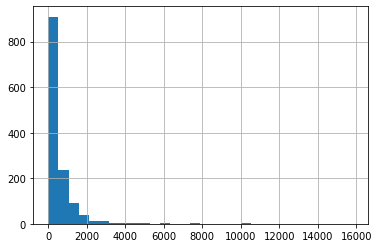

In [14]:
q5= """
    SELECT       
        Discount,          
        ((OrderDetail.UnitPrice * Quantity) * (1 - Discount)) AS TotalPaid
    FROM OrderDetail 
    JOIN Product ON OrderDetail.ProductId = Product.Id
    WHERE Discount = 0
    ORDER BY TotalPaid DESC
    
    
"""

cursor = cur.execute(q5)
names = [description[0] for description in cursor.description]
df_totals_no_disc = pd.DataFrame(cursor.fetchall(),columns=names)
display(df_totals_no_disc)
df_totals_no_disc['TotalPaid'].hist(bins = 30)e

## Testing the Null

In [19]:
pd.set_option('display.float_format', lambda x:'%.6f' % x)
control2 = df_totals_no_disc['TotalPaid']
experiment2 = df_totals_disc['TotalPaid']

hyp2 = hyp_test_mean(control2,experiment2)
display(hyp2)

,p_value,notes,Null Rejected
Difference in means,0.000000,44.664619,True
Cohen's d,0.000000,0.046084,True
Sample A normality,0.000000,0,True
Samp B normality,0.000000,0,True
Variance similarity,0.476733,0,False
t_test,0.297115,1 !!Best Test!!,False
Welch's t-test,0.299355,not used; t-test assumptions met,False
Mann Whitney U,0.032567,not needed; t-test assumptions met,True


In [24]:
h2_p = monte_carlo(control2,experiment2,30000)
print(h2_p)

0.1478


## Conclusion

We saw that a ttest was the most reliable mathematical test, given that the variances of the two samples was very similar (which we saw both from the Leven calculated p-value in the test report as well as by eyeballing the histograms). Note that this is a two sided pval: the probability of observing a mean at least as high as the experimental mean would be half of this i.e. around 0.15. This is further coroborated by our Monte Carlo simlation which also shows that 15% of random samples pulled from the pooled samples resulted in a mean difference higher than that observed in the original samples. This is essentially the same value as our p-value. from the t test. 

Based on the tests, we are unable to dismiss the null hypothesis that purchases with discounts applied yield the same revenue are orders without any discounts applied. Therefore, it seems that there is no statistically significant difference in the revenue generated by discounted orders versus orders without discounts. 

# Third Hypothesis

The next issue I want to explore is the impact of sales

,TotalPaid,DiscAmount,OrderID,RevPerOrder
EmpName,,,,
Robert King,114583.6725,16259.5675,150,763.891150
Anne Dodsworth,77308.0665,5655.9335,107,722.505294
Andrew Fuller,165585.0550,11176.1050,237,698.671118
Janet Leverling,201054.9430,10238.4570,313,642.348061
Margaret Peacock,228854.4960,16890.9540,408,560.917882
Nancy Davolio,191025.4395,9892.5705,341,560.191905
Steven Buchanan,59581.3825,3705.1675,113,527.268872
Laura Callahan,119964.2175,5696.1625,248,483.726683
Michael Suyama,70018.1920,4150.6580,161,434.895602


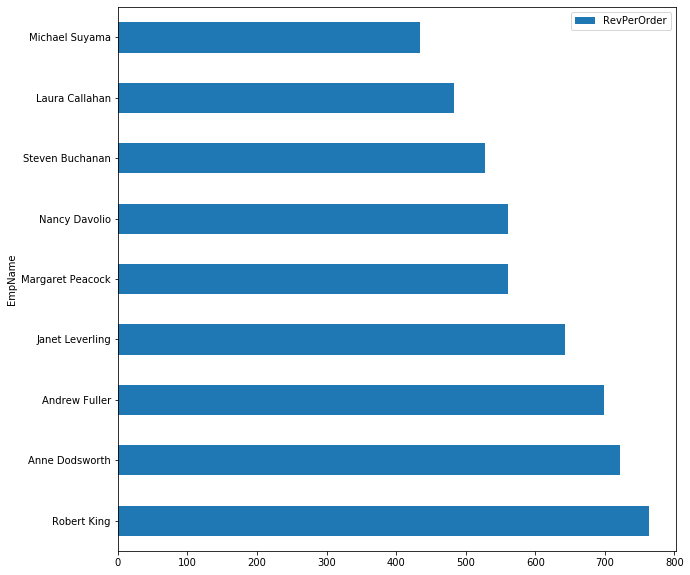

In [14]:
df_emp performance = df_master.groupby('EmpName').agg({'TotalPaid':'sum','DiscAmount':'sum','OrderID':'count'})

df_big_customers['RevPerOrder'] = df_big_customers['TotalPaid'] /df_big_customers['OrderID']
df_big_customers.sort_values(by='RevPerOrder',ascending=False,inplace=True)

df_big_customers.plot(y='RevPerOrder',kind='barh',figsize=(10,10))
display(df_big_customers)

In [32]:
pd.set_option('display.float_format', lambda x:'%.6f' % x)

highest_emp = df_master[df_master['EmpName'] == 'Robert King']['TotalPaid']
remain_emps = df_master.drop(highest_emp.index)['TotalPaid']

emp_hyp = hyp_test_mean(remain_emps,highest_emp)


,p_value,notes,Null Rejected
Difference in means,0.000000,186.405781,True
Cohen's d,0.000000,0.191265,True
Sample A normality,0.000000,0,True
Samp B normality,0.000000,0,True
Variance similarity,0.032848,0,True
t_test,0.024128,not used: assumptions not met,True
Welch's t-test,0.081602,1 !!Best Test!!,False
Mann Whitney U,0.116643,not needed: Welch's assumptions met,False


                     p_value                                notes  \
Difference in means 0.000000                           186.405781   
Cohen's d           0.000000                             0.191265   
Sample A normality  0.000000                                    0   
Samp B normality    0.000000                                    0   
Variance similarity 0.032848                                    0   
t_test              0.024128        not used: assumptions not met   
Welch's t-test      0.081602                      1 !!Best Test!!   
Mann Whitney U      0.116643  not needed: Welch's assumptions met   

                     Null Rejected  
Difference in means           True  
Cohen's d                     True  
Sample A normality            True  
Samp B normality              True  
Variance similarity           True  
t_test                        True  
Welch's t-test               False  
Mann Whitney U               False  


# Exploration

In [27]:
# Highest revenue items

q3= """
    SELECT 
        ProductName,
        Quantity,
        Discount,        
        Product.UnitPrice AS PriceCharged,        
        (OrderDetail.UnitPrice * Quantity) * (1 - Discount) AS TotalPaid
    FROM OrderDetail 
    JOIN Product ON OrderDetail.ProductId = Product.Id
    JOIN 
    ORDER BY TotalPaid DESC
    
    
"""

cursor = cur.execute(q3)
names = [description[0] for description in cursor.description]
df3 = pd.DataFrame(cursor.fetchall(),columns=names)
display(df3)

,ProductName,Quantity,Discount,PriceCharged,TotalPaid
0,Côte de Blaye,60,0.000000,263.500000,15810.000000
1,Côte de Blaye,60,0.050000,263.500000,15019.500000
2,Côte de Blaye,50,0.000000,263.500000,10540.000000
3,Côte de Blaye,40,0.000000,263.500000,10540.000000
4,Thüringer Rostbratwurst,80,0.000000,123.790000,9903.200000
...,...,...,...,...,...
2150,Gorgonzola Telino,1,0.000000,12.500000,12.500000
2151,Konbu,2,0.100000,6.000000,8.640000
2152,Geitost,4,0.150000,2.500000,8.500000
2153,Teatime Chocolate Biscuits,1,0.000000,9.200000,7.300000


What is the most profitable product?


,TotalPaid,DiscAmount,OrderID
CompanyName,,,
QUICK-Stop,110277.305000,7206.085000,86
Ernst Handel,104874.978500,8361.701500,102
Save-a-lot Markets,104361.950000,11311.440000,116
Rattlesnake Canyon Grocery,51097.800500,1148.099500,71
Hungry Owl All-Night Grocers,49979.905000,7337.485000,55
...,...,...,...
Galería del gastrónomo,836.700000,0.000000,8
North/South,649.000000,0.000000,6
Laughing Bacchus Wine Cellars,522.500000,0.000000,8


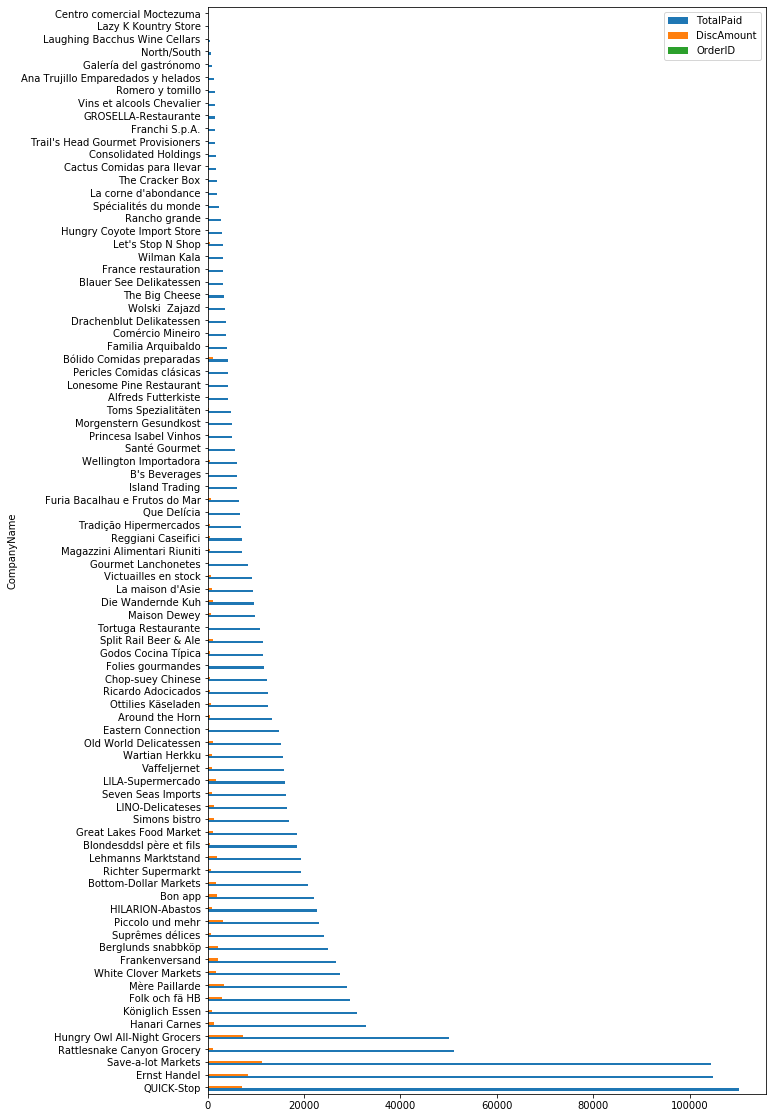

In [64]:
df_big_customers = df_master.groupby('CompanyName').agg({'TotalPaid':'sum','DiscAmount':'sum'}).sort_values(by='TotalPaid',ascending=False)

display(df_big_customers)

df_big_customers.plot(kind='barh',figsize=(10,20))

,TotalPaid,DiscAmount
ProductName,,
Côte de Blaye,135072.735000,6479.465000
Thüringer Rostbratwurst,80368.672000,7367.728000
Raclette Courdavault,70303.200000,5057.800000
Tarte au sucre,47234.970000,2592.930000
Camembert Pierrot,44887.480000,2984.520000
...,...,...
Longlife Tofu,2432.500000,133.500000
Laughing Lumberjack Lager,2396.800000,165.200000
Genen Shouyu,1784.825000,28.675000


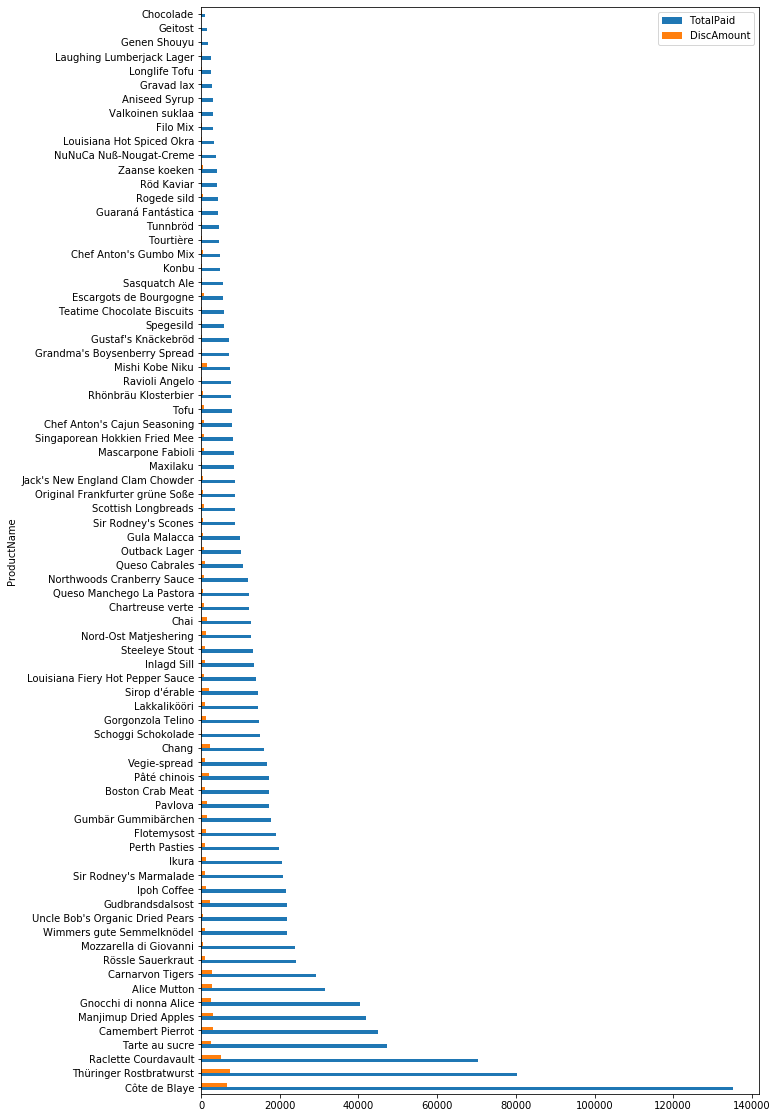

In [60]:
df_big_customers = df_master.groupby('ProductName').agg({'TotalPaid':'sum','DiscAmount':'sum'}).sort_values(by='TotalPaid',ascending=False)

display(df_big_customers)

df_big_customers.plot(kind='barh',figsize=(10,20))